[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab9_transfer_learning.ipynb)

# Transfer Learning/Fine-Tuning

During training, neural networks often learn features that are useful for a wide variety of tasks. For example, the earliest layers of convolution networks often learn very basic visual features, such as edge detection. These task-agnostic features can be very useful when applied to other tasks. Transfer learning or fine-tuning is a technique that takes a network pretrained on one task and trains it on another. The idea is to tweak or tune the parameters on the new task, rather than making huge changes in learning. Fine-tuning is often quicker than learning on the new task from scratch, and can even lead to better overall performance and generalization.

Unfreezing a pretrained network is a fine-tuning technique that can be helpful when training a network on a difficult task with limited data.
If we allow the network to train its earliest layers immediately, then the earliest layers will forget all of the useful task-agnostic features they learned previously. So, rather than training all of the model weights at once, we learn on the last few layers (which are the most task-specific in the network). We can also gradually start training on the earlier layers as training progresses.

In this lab, you will compare unfreezing fine-tuning techniques against training a model from scratch. You will use the large ResNet-152 model to learn the small Bird Species Classification dataset.


### Grading

- 20% Analyze Dataset
- 20% Implementing `BirdNet`
- 20% Implementing `train()`
- 30% Running finetuning experiment
- 10% Answering questions


In [105]:
import zipfile
import os
import sys
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import time
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
from tqdm import tqdm

In [3]:
device = torch.device("cuda")

## Analyze `BirdDataset`

Start by first downloading the dataset from Kaggle.

#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab.

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [4]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
# from google.colab import files
# files.upload()
# Next, install the Kaggle API client.
# !pip install -q kaggle
# Let's make sure the kaggle.json file is present.
# !ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json

3. Copy the desired dataset locally

In [5]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
# !kaggle datasets download -d akash2907/bird-species-classification

The `BirdDataset` is implemented for you below. Instantiate a `train_dataset` and `val_dataset`.

In [6]:
class BirdDataset(Dataset):
    def __init__(self, zip_file='bird-species-classification.zip', size=256, train=True, upload=False):
        super(BirdDataset, self).__init__()

        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # We resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        if train:
            # The bird-species dataset mistakenly has a train_data folder inside of train_data
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)
                else:
                    print(f"else {name}")

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

In [7]:
train_dataset = BirdDataset(
    zip_file="data/bird-species-classification.zip",
    train=True
)

val_dataset = BirdDataset(
    zip_file="data/bird-species-classification.zip",
    train=False
)

Extracting data/bird-species-classification.zip
Resizing images


Print out the number of instances of each class in the `train_dataset` and `val_dataset`.

In [8]:
print(f"train_dataset has {len(train_dataset)} instances.")
print(f"val_dataset has {len(val_dataset)} instances.")

train_dataset has 150 instances.
val_dataset has 157 instances.


Print out a single image for each class in a 4x4 display.

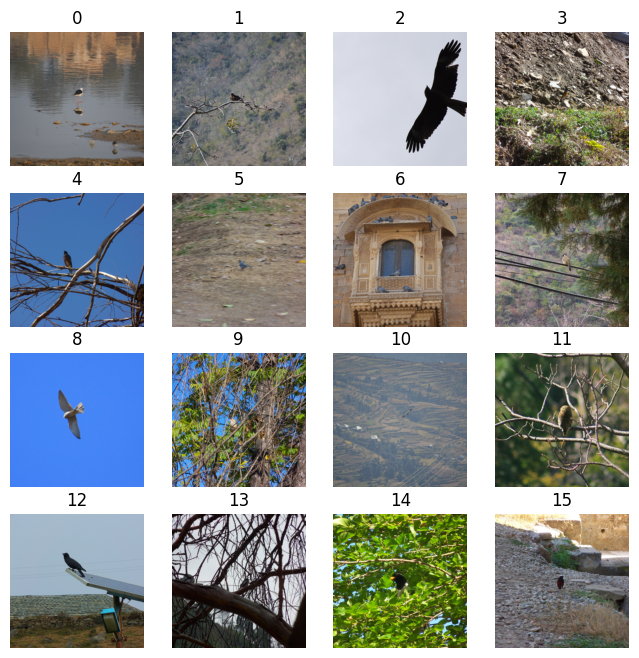

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

indices = [0, 15, 21, 26, 33, 40, 46, 56, 74, 94, 103, 112, 118, 124, 130, 140]
for i, ax in enumerate(axes.flat):
    j = indices[i]
    X, y = train_dataset[j]
    ax.imshow(X.permute(1, 2, 0))
    ax.set_title(y)
    ax.set_axis_off()

You will notice that not only do we have a small training dataset (150 images), some of the images are potentially difficult to classify because of how small the bird appears in the image. If you investigated the images further you would notice that many images of a given class are subsequent snapshots of the same bird. This will make generalization hard and overfitting easy, especially with a large network.

## Implement `BirdNet`


Implement the `BirdNet`: a wrapper class adding functionality to a (pretrained) `ResNet`.

### Implement `__init__()`
- The `BirdNet` should first instantiate a `models.resnet152` object and optionally, load in pretrained weights (look at https://pytorch.org/vision/stable/models.html for more information about using pretrained weights). We suggest using `models.ResNet152_Weights.IMAGENET1K_V1`.
- Overwrite the final layer in the ResNet to linearly map (with `nn.Linear`) the previous layers features to `n_classes`.
- Freeze all weights except the final layer. You can do this with calling `.requires_grad = False` on the parameters or calling `.requires_grad(False)` on the layers.


### Implement `unfreeze()`
Implement `unfreeze()` to unfreeze the last `n_layers` of your model. Do not treat the sequential or bottleneck layers in the ResNet as a single layer; we consider a convolutional layer or linear layer as a single layer. You may optionally treat a batchnorm layer as its own layer or as part of a conv/linear layer. ReLU layers do not have parameters, so they can't be frozen/unfrozen.


**Tip**: *You can print out a `models.resnet152` object to get an idea of how many input features are used in the last layer as well as the structure and naming convention used by the ResNet to know how to unfreeze `n_layers`.*


Create a temporary resnet152 model and print it here to see the structure of the network and the naming conventions. You can iterate over `.named_parameters()` to get the name and parameter object, respectively, to verify the naming scheme. This function can make your unfreezing function simpler.

In [87]:
temp = models.resnet152()
for name, parameters in temp.named_parameters():
    print(name, parameters.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [88]:
class BirdNet(nn.Module):
    def __init__(self, n_classes, pretrained_weights):
        super().__init__()
        self.net = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1 if pretrained_weights else None)
        
        in_features = self.net.fc.in_features
        
        self.net.fc = nn.Linear(in_features, n_classes)
        
        for param in self.net.parameters():
            param.requires_grad = False
        
        for param in self.net.fc.parameters():
            param.requires_grad = True

    def unfreeze(self, n_layers):
        layers = []
        
        for name, module in self.net.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
                layers.append(module)
        
        for layer in layers[-n_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.net(x)

## Training

In [112]:
@torch.no_grad()
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc.item()


@torch.no_grad()
def evaluate(model, loss_fn, val_loader):
    val_losses = 0
    val_accs = 0
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()

    for x, y_truth in tqdm(val_loader, "Validating"):
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        val_losses += loss_fn(y_hat, y_truth).item() * len(x)
        val_accs += accuracy(y_hat, y_truth) * len(x)

    model.train()
    return val_losses/len(val_dataset), val_accs/len(val_dataset)


Implement the `train()` function. Keep track of the usual performance metrics (training/validation losses and accuracies) and additionally keep track of how long, in seconds, training took (this is referred to as wallclock training time).

There are two additional arguments in `train()`: `slowly_unfreeze` and `unfreeze_interval`.
 If `slowly_unfreeze=True` then for every `unfreeze_interval` number of steps you should unfreeze an additional layer from your model.

In [120]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

In [131]:
def train(model, optimizer, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval):   
    criterion = nn.CrossEntropyLoss()
    
    training_losses = []
    training_accuracies = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()
    
    step = 1
    while step <= n_optimization_steps:

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_hat = model(x)
            loss = criterion(y_hat, y)

            loss.backward()

            optimizer.step()
            
            train_accuracy = accuracy(y_hat, y)
            
            training_losses.append(loss.item())
            training_accuracies.append(train_accuracy)
            
            # print(f"Step {step}/{n_optimization_steps} - Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}")
            
            if step % log_interval == 0:
                val_loss, val_accuracy = evaluate(model, criterion, val_loader)

                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

                print(f"Step {step}/{n_optimization_steps} - Val Loss: {val_loss:.4f}, Train Accuracy: {val_accuracy:.4f}")
            
            if slowly_unfreeze and step % unfreeze_interval == 0:
                model.unfreeze(1)

            if step > n_optimization_steps:
                break

            step += 1
    
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")
    return training_losses, training_accuracies, val_losses, val_accuracies, total_time

To compare how well finetuning works you will perform a set of experiments. There are four models you will train for `n_trials >= 3`:
- `res-reinit`: A reinitialized (not pretrained) resnet model. This is the baseline.
- `res1`: A pretrained resnet model with only the last layer unfrozen.
- `res3`: A pretrained resnet model with the last 3 layers unfrozen.
- `res10-slow`: A pretrained resnet model with the last last 10 layers **slowly** unfrozen.

For each model average the results across the `n_trials` and plot the val accuracy across time for each model and print out the average wallclock time and time per optimization step (i.e. wallclock_time / optimization_step) . **Do not forget to recreate the model and optimizer between each trial.**


**Tip:** Make sure everything is implemented correctly before running all `n_trials` on all four models. We found that a learning rate of .001 worked well for 100 optimization steps.

In [132]:
def create_model(model_type, n_classes=16):
    if model_type == "res-reinit":
        model = BirdNet(n_classes, pretrained_weights=False)
    else:
        model = BirdNet(n_classes, pretrained_weights=True)
    
    if model_type == "res1":
        model.unfreeze(1)  

    elif model_type == "res3":
        model.unfreeze(3)  

    elif model_type == "res10-slow":
        model.unfreeze(10) 
    
    return model

In [145]:
n_trials = 3
n_optimization_steps = 200
log_interval = 10
learning_rate = 0.001
unfreeze_interval = 1  # Only relevant for res10-slow

model_types = ["res-reinit", "res1", "res3", "res10-slow"]
val_accuracies_over_time = {m: [] for m in model_types}
wallclock_times = {m: [] for m in model_types}
time_per_step = {m: [] for m in model_types}

for model_type in model_types:
    print(f"\nTraining {model_type} model...")
    
    trial_times = []
    trial_accuracies = []
    
    for trial in range(n_trials):
        print(f"\nTrial {trial+1}/{n_trials} for {model_type}...")
        
        model = create_model(model_type).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        _, _, _, val_accuracies, total_time = train(
            model=model, 
            optimizer=optimizer, 
            n_optimization_steps=n_optimization_steps, 
            log_interval=log_interval,
            slowly_unfreeze=(model_type == "res10-slow"),
            unfreeze_interval=unfreeze_interval,
        )
        
        trial_accuracies.append(val_accuracies)
        trial_times.append(total_time)
    
    # Store results
    avg_val_accuracies = np.mean(trial_accuracies, axis=0)
    avg_wallclock_time = np.mean(trial_times)
    avg_time_per_step = avg_wallclock_time / n_optimization_steps

    val_accuracies_over_time[model_type] = avg_val_accuracies
    wallclock_times[model_type] = avg_wallclock_time
    time_per_step[model_type] = avg_time_per_step


Training res-reinit model...

Trial 1/3 for res-reinit...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 10/200 - Val Loss: 2.8673, Train Accuracy: 0.0701


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 20/200 - Val Loss: 2.8575, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 30/200 - Val Loss: 2.9811, Train Accuracy: 0.0637



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 40/200 - Val Loss: 2.9262, Train Accuracy: 0.0637


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 50/200 - Val Loss: 2.9461, Train Accuracy: 0.0637


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 60/200 - Val Loss: 2.9277, Train Accuracy: 0.0701



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 70/200 - Val Loss: 2.8706, Train Accuracy: 0.0764


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 80/200 - Val Loss: 2.8372, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 90/200 - Val Loss: 2.8868, Train Accuracy: 0.0892



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 100/200 - Val Loss: 2.9084, Train Accuracy: 0.0764


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 110/200 - Val Loss: 2.8967, Train Accuracy: 0.0828


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 120/200 - Val Loss: 2.9231, Train Accuracy: 0.0764



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 130/200 - Val Loss: 2.9488, Train Accuracy: 0.0764


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 140/200 - Val Loss: 2.9309, Train Accuracy: 0.1019


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 150/200 - Val Loss: 2.9500, Train Accuracy: 0.0764



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 160/200 - Val Loss: 2.9723, Train Accuracy: 0.0892


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Step 170/200 - Val Loss: 2.9522, Train Accuracy: 0.1210


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 180/200 - Val Loss: 2.9707, Train Accuracy: 0.0764



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 190/200 - Val Loss: 2.9974, Train Accuracy: 0.1083


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 200/200 - Val Loss: 2.9744, Train Accuracy: 0.1592
Training completed in 103.78 seconds

Trial 2/3 for res-reinit...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 10/200 - Val Loss: 2.8203, Train Accuracy: 0.0637


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 20/200 - Val Loss: 2.8580, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

Step 30/200 - Val Loss: 2.9642, Train Accuracy: 0.0637



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 40/200 - Val Loss: 2.9057, Train Accuracy: 0.0637


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Step 50/200 - Val Loss: 2.9222, Train Accuracy: 0.0637


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 60/200 - Val Loss: 2.8929, Train Accuracy: 0.0637



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 70/200 - Val Loss: 2.8475, Train Accuracy: 0.0828


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 80/200 - Val Loss: 2.8067, Train Accuracy: 0.0828


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

Step 90/200 - Val Loss: 2.8451, Train Accuracy: 0.0828



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 100/200 - Val Loss: 2.8409, Train Accuracy: 0.0828


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 110/200 - Val Loss: 2.8275, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 120/200 - Val Loss: 2.8632, Train Accuracy: 0.0828



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Step 130/200 - Val Loss: 2.8663, Train Accuracy: 0.0828


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 140/200 - Val Loss: 2.8583, Train Accuracy: 0.0892


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 150/200 - Val Loss: 2.8856, Train Accuracy: 0.0828



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 160/200 - Val Loss: 2.8896, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 170/200 - Val Loss: 2.8778, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

Step 180/200 - Val Loss: 2.9067, Train Accuracy: 0.0828



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 190/200 - Val Loss: 2.9040, Train Accuracy: 0.0892


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 200/200 - Val Loss: 2.8965, Train Accuracy: 0.0955
Training completed in 103.87 seconds

Trial 3/3 for res-reinit...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 10/200 - Val Loss: 2.8466, Train Accuracy: 0.0637


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 20/200 - Val Loss: 2.8221, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 30/200 - Val Loss: 3.0082, Train Accuracy: 0.0637



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Step 40/200 - Val Loss: 2.9809, Train Accuracy: 0.0510


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Step 50/200 - Val Loss: 2.9201, Train Accuracy: 0.0637


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 60/200 - Val Loss: 2.9161, Train Accuracy: 0.0637



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 70/200 - Val Loss: 2.8752, Train Accuracy: 0.0828


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 80/200 - Val Loss: 2.8484, Train Accuracy: 0.0955


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 90/200 - Val Loss: 2.9046, Train Accuracy: 0.0892



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 100/200 - Val Loss: 2.9274, Train Accuracy: 0.1019


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 110/200 - Val Loss: 2.9187, Train Accuracy: 0.1338


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

Step 120/200 - Val Loss: 2.9553, Train Accuracy: 0.1019



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 130/200 - Val Loss: 2.9674, Train Accuracy: 0.1338


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 140/200 - Val Loss: 2.9544, Train Accuracy: 0.1529


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 150/200 - Val Loss: 2.9848, Train Accuracy: 0.1210



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 160/200 - Val Loss: 2.9956, Train Accuracy: 0.1656


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 170/200 - Val Loss: 2.9851, Train Accuracy: 0.1592


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 180/200 - Val Loss: 3.0088, Train Accuracy: 0.1401



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 190/200 - Val Loss: 3.0210, Train Accuracy: 0.1656


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Step 200/200 - Val Loss: 3.0119, Train Accuracy: 0.1656
Training completed in 103.94 seconds

Training res1 model...

Trial 1/3 for res1...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 10/200 - Val Loss: 2.8931, Train Accuracy: 0.1019


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 20/200 - Val Loss: 2.3072, Train Accuracy: 0.3567


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 30/200 - Val Loss: 2.2273, Train Accuracy: 0.3439



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 40/200 - Val Loss: 2.1234, Train Accuracy: 0.4076


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 50/200 - Val Loss: 1.9847, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 60/200 - Val Loss: 2.0105, Train Accuracy: 0.4777



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Step 70/200 - Val Loss: 1.9626, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 80/200 - Val Loss: 1.9316, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 90/200 - Val Loss: 1.9546, Train Accuracy: 0.4904



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Step 100/200 - Val Loss: 1.9361, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 110/200 - Val Loss: 1.9199, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 120/200 - Val Loss: 1.9454, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 130/200 - Val Loss: 1.9351, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 140/200 - Val Loss: 1.9217, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 150/200 - Val Loss: 1.9486, Train Accuracy: 0.5032



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 160/200 - Val Loss: 1.9401, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 170/200 - Val Loss: 1.9280, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 180/200 - Val Loss: 1.9554, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 190/200 - Val Loss: 1.9477, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 200/200 - Val Loss: 1.9359, Train Accuracy: 0.5096
Training completed in 104.57 seconds

Trial 2/3 for res1...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 10/200 - Val Loss: 2.8701, Train Accuracy: 0.0892


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 20/200 - Val Loss: 2.2979, Train Accuracy: 0.3631


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 30/200 - Val Loss: 2.2079, Train Accuracy: 0.3758



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 40/200 - Val Loss: 2.0897, Train Accuracy: 0.4650


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 50/200 - Val Loss: 1.9581, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

Step 60/200 - Val Loss: 1.9805, Train Accuracy: 0.5223



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 70/200 - Val Loss: 1.9359, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 80/200 - Val Loss: 1.9088, Train Accuracy: 0.5159


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 90/200 - Val Loss: 1.9270, Train Accuracy: 0.5096



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 100/200 - Val Loss: 1.9112, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Step 110/200 - Val Loss: 1.8983, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

Step 120/200 - Val Loss: 1.9191, Train Accuracy: 0.5223



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 130/200 - Val Loss: 1.9112, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 140/200 - Val Loss: 1.9012, Train Accuracy: 0.5159


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

Step 150/200 - Val Loss: 1.9232, Train Accuracy: 0.5223



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 160/200 - Val Loss: 1.9170, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 170/200 - Val Loss: 1.9081, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 180/200 - Val Loss: 1.9308, Train Accuracy: 0.5032



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 190/200 - Val Loss: 1.9253, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 200/200 - Val Loss: 1.9167, Train Accuracy: 0.5159
Training completed in 104.23 seconds

Trial 3/3 for res1...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 10/200 - Val Loss: 2.8279, Train Accuracy: 0.0701


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 20/200 - Val Loss: 2.2975, Train Accuracy: 0.3376


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 30/200 - Val Loss: 2.2172, Train Accuracy: 0.3694



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 40/200 - Val Loss: 2.1124, Train Accuracy: 0.4459


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 50/200 - Val Loss: 1.9887, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 60/200 - Val Loss: 2.0113, Train Accuracy: 0.4841



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 70/200 - Val Loss: 1.9656, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 80/200 - Val Loss: 1.9373, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

Step 90/200 - Val Loss: 1.9548, Train Accuracy: 0.5032



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 100/200 - Val Loss: 1.9375, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 110/200 - Val Loss: 1.9242, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

Step 120/200 - Val Loss: 1.9443, Train Accuracy: 0.5032



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 130/200 - Val Loss: 1.9348, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 140/200 - Val Loss: 1.9247, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 150/200 - Val Loss: 1.9465, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 160/200 - Val Loss: 1.9389, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Step 170/200 - Val Loss: 1.9303, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 180/200 - Val Loss: 1.9529, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 190/200 - Val Loss: 1.9461, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 200/200 - Val Loss: 1.9379, Train Accuracy: 0.4904
Training completed in 104.49 seconds

Training res3 model...

Trial 1/3 for res3...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 10/200 - Val Loss: 2.4658, Train Accuracy: 0.2803


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 20/200 - Val Loss: 2.0245, Train Accuracy: 0.4459


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 30/200 - Val Loss: 1.8712, Train Accuracy: 0.5096



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 40/200 - Val Loss: 1.7917, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 50/200 - Val Loss: 1.8077, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 60/200 - Val Loss: 1.8411, Train Accuracy: 0.5350



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Step 70/200 - Val Loss: 1.8355, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 80/200 - Val Loss: 1.8300, Train Accuracy: 0.5414


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 90/200 - Val Loss: 1.8354, Train Accuracy: 0.5350



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 100/200 - Val Loss: 1.8335, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 110/200 - Val Loss: 1.8350, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 120/200 - Val Loss: 1.8441, Train Accuracy: 0.5350



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Step 130/200 - Val Loss: 1.8447, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 140/200 - Val Loss: 1.8476, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 150/200 - Val Loss: 1.8559, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 160/200 - Val Loss: 1.8561, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 170/200 - Val Loss: 1.8592, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 180/200 - Val Loss: 1.8664, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 190/200 - Val Loss: 1.8669, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 200/200 - Val Loss: 1.8703, Train Accuracy: 0.5350
Training completed in 104.52 seconds

Trial 2/3 for res3...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Step 10/200 - Val Loss: 2.4939, Train Accuracy: 0.2803


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 20/200 - Val Loss: 2.0253, Train Accuracy: 0.4586


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

Step 30/200 - Val Loss: 1.8620, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 40/200 - Val Loss: 1.7699, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 50/200 - Val Loss: 1.7891, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

Step 60/200 - Val Loss: 1.8261, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 70/200 - Val Loss: 1.8226, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 80/200 - Val Loss: 1.8181, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 90/200 - Val Loss: 1.8255, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Step 100/200 - Val Loss: 1.8229, Train Accuracy: 0.5414


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 110/200 - Val Loss: 1.8240, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 120/200 - Val Loss: 1.8358, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 130/200 - Val Loss: 1.8358, Train Accuracy: 0.5414


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 140/200 - Val Loss: 1.8383, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 150/200 - Val Loss: 1.8492, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 160/200 - Val Loss: 1.8487, Train Accuracy: 0.5414


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 170/200 - Val Loss: 1.8511, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 180/200 - Val Loss: 1.8609, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 190/200 - Val Loss: 1.8606, Train Accuracy: 0.5414


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Step 200/200 - Val Loss: 1.8630, Train Accuracy: 0.5287
Training completed in 104.74 seconds

Trial 3/3 for res3...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 10/200 - Val Loss: 2.3651, Train Accuracy: 0.2930


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 20/200 - Val Loss: 1.9795, Train Accuracy: 0.4650


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 30/200 - Val Loss: 1.8571, Train Accuracy: 0.5096



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 40/200 - Val Loss: 1.7732, Train Accuracy: 0.5478


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 50/200 - Val Loss: 1.7859, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

Step 60/200 - Val Loss: 1.8143, Train Accuracy: 0.5287



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 70/200 - Val Loss: 1.8110, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 80/200 - Val Loss: 1.8083, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 90/200 - Val Loss: 1.8133, Train Accuracy: 0.5287



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 100/200 - Val Loss: 1.8127, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 110/200 - Val Loss: 1.8144, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 120/200 - Val Loss: 1.8212, Train Accuracy: 0.5287



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 130/200 - Val Loss: 1.8221, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 140/200 - Val Loss: 1.8252, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

Step 150/200 - Val Loss: 1.8316, Train Accuracy: 0.5287



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Step 160/200 - Val Loss: 1.8326, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 170/200 - Val Loss: 1.8362, Train Accuracy: 0.5414


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 180/200 - Val Loss: 1.8417, Train Accuracy: 0.5350



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 190/200 - Val Loss: 1.8430, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Step 200/200 - Val Loss: 1.8468, Train Accuracy: 0.5414
Training completed in 104.06 seconds

Training res10-slow model...

Trial 1/3 for res10-slow...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 10/200 - Val Loss: 2.2232, Train Accuracy: 0.4076


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Step 20/200 - Val Loss: 2.2637, Train Accuracy: 0.4331


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 30/200 - Val Loss: 2.1375, Train Accuracy: 0.4777



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 40/200 - Val Loss: 2.0225, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 50/200 - Val Loss: 2.0064, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

Step 60/200 - Val Loss: 2.0127, Train Accuracy: 0.5287



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Step 70/200 - Val Loss: 1.9914, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Step 80/200 - Val Loss: 1.9972, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 90/200 - Val Loss: 1.9980, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Step 100/200 - Val Loss: 1.9787, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Step 110/200 - Val Loss: 1.9861, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 120/200 - Val Loss: 1.9878, Train Accuracy: 0.5414



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Step 130/200 - Val Loss: 1.9711, Train Accuracy: 0.5223


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Step 140/200 - Val Loss: 1.9812, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 150/200 - Val Loss: 1.9826, Train Accuracy: 0.5287



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 160/200 - Val Loss: 1.9672, Train Accuracy: 0.5287


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 170/200 - Val Loss: 1.9789, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 180/200 - Val Loss: 1.9793, Train Accuracy: 0.5350



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 190/200 - Val Loss: 1.9651, Train Accuracy: 0.5350


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 200/200 - Val Loss: 1.9777, Train Accuracy: 0.5350
Training completed in 105.75 seconds

Trial 2/3 for res10-slow...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 10/200 - Val Loss: 2.3538, Train Accuracy: 0.3822


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 20/200 - Val Loss: 2.4773, Train Accuracy: 0.4076


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 30/200 - Val Loss: 2.3145, Train Accuracy: 0.4459



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 40/200 - Val Loss: 2.1416, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 50/200 - Val Loss: 2.1089, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 60/200 - Val Loss: 2.1078, Train Accuracy: 0.5096



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Step 70/200 - Val Loss: 2.0739, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 80/200 - Val Loss: 2.0735, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 90/200 - Val Loss: 2.0775, Train Accuracy: 0.5096



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 100/200 - Val Loss: 2.0547, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 110/200 - Val Loss: 2.0591, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 120/200 - Val Loss: 2.0655, Train Accuracy: 0.5096



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 130/200 - Val Loss: 2.0466, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Step 140/200 - Val Loss: 2.0536, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

Step 150/200 - Val Loss: 2.0595, Train Accuracy: 0.5096



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 160/200 - Val Loss: 2.0421, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 170/200 - Val Loss: 2.0503, Train Accuracy: 0.5096


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

Step 180/200 - Val Loss: 2.0553, Train Accuracy: 0.5159



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 190/200 - Val Loss: 2.0394, Train Accuracy: 0.5032


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Step 200/200 - Val Loss: 2.0485, Train Accuracy: 0.5096
Training completed in 105.53 seconds

Trial 3/3 for res10-slow...


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Step 10/200 - Val Loss: 2.3621, Train Accuracy: 0.3885


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Step 20/200 - Val Loss: 2.3474, Train Accuracy: 0.4076


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 30/200 - Val Loss: 2.2619, Train Accuracy: 0.4841



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 40/200 - Val Loss: 2.1613, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 50/200 - Val Loss: 2.1386, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 60/200 - Val Loss: 2.1450, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 70/200 - Val Loss: 2.1170, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Step 80/200 - Val Loss: 2.1149, Train Accuracy: 0.4841


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Step 90/200 - Val Loss: 2.1218, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Step 100/200 - Val Loss: 2.1011, Train Accuracy: 0.4841


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 110/200 - Val Loss: 2.1038, Train Accuracy: 0.4841


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

Step 120/200 - Val Loss: 2.1123, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Step 130/200 - Val Loss: 2.0947, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 140/200 - Val Loss: 2.0995, Train Accuracy: 0.4841


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

Step 150/200 - Val Loss: 2.1073, Train Accuracy: 0.4968



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Step 160/200 - Val Loss: 2.0908, Train Accuracy: 0.4904


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Step 170/200 - Val Loss: 2.0965, Train Accuracy: 0.4841


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Step 180/200 - Val Loss: 2.1034, Train Accuracy: 0.4904



Validating: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Step 190/200 - Val Loss: 2.0880, Train Accuracy: 0.4968


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Step 200/200 - Val Loss: 2.0945, Train Accuracy: 0.4904
Training completed in 105.65 seconds


In [152]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

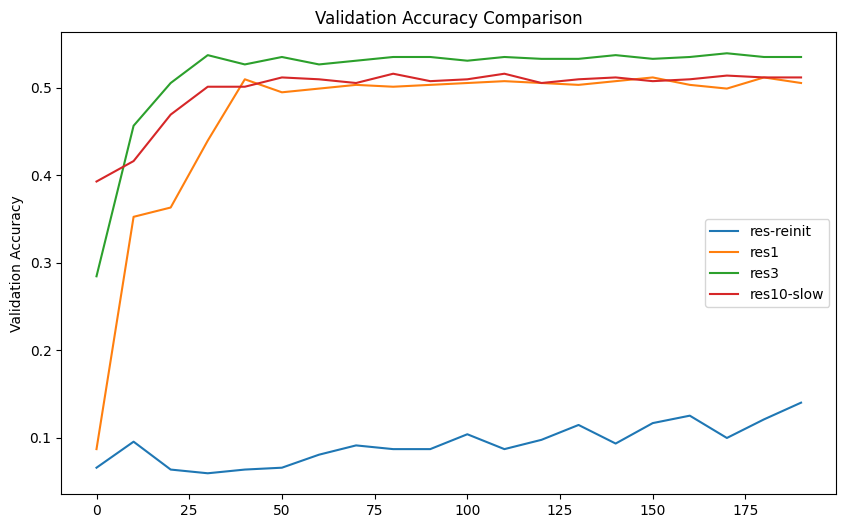

In [153]:
plt.figure(figsize=(10, 6))
for model, accuracies in val_accuracies_over_time.items():
    plt.plot(range(0, n_optimization_steps, log_interval), accuracies, label=model)
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

In [147]:
# Print time statistics
for model_type in model_types:
    print(f"{model_type}: Avg Wallclock Time = {wallclock_times[model_type]:.2f} sec, Time per Step = {time_per_step[model_type]:.4f} sec")

res-reinit: Avg Wallclock Time = 103.86 sec, Time per Step = 0.5193 sec
res1: Avg Wallclock Time = 104.43 sec, Time per Step = 0.5222 sec
res3: Avg Wallclock Time = 104.44 sec, Time per Step = 0.5222 sec
res10-slow: Avg Wallclock Time = 105.64 sec, Time per Step = 0.5282 sec


### Questions
- Which model performed the best?
- How do the finetuned models compare to the reinitialized model in terms of time?
- Why are the ImageNet weights helpful to learning the Bird dataset?
- Why do we only unfreeze the last few layers?
- What are some pros and cons of pretraining?


1. The model that performed the best was the res3 model. This model had the last three layers of the resnet model unfrozen, and proved superior to the single unfrozen version as well as the slow unfreezing version.
2. All of the finetuned models perform much better than the baseline model. This is obviously due to the baseline model being totally random and not having enough data points to improve on it's own.
3. The ImageNet weights are helpful to learning the Bird dataset since they are accomplishing a similar task in their original training to the new task (image detection).
4. We only unfreeze the last few layers because it allows us to slightly modify the ending outputs of the model, while keeping the lower dimensional features deeper in the model. 
5. One of the pros of pretraining is that we are able to train a new model much faster on pretrained weights than if we had started from scratch. One of the cons is that if there is no good pretrained model for us to use, then we are unable to truly benefit from the pretrained weights.